In [320]:
import glob
import random

import numpy as np
import pyrender
import trimesh
from PIL import Image

In [321]:
import os
os.environ['PYOPENGL_PLATFORM'] = 'egl'

In [322]:
files = glob.glob("citydata/buildingnet/OBJ_MODELS/*.obj")

In [323]:
file = random.choice(files)

In [324]:
scene = trimesh.load(file)

In [326]:
# Ensure model is directly in center of camera
scene.apply_translation(-scene.centroid)

<trimesh.Scene(len(geometry)=21)>

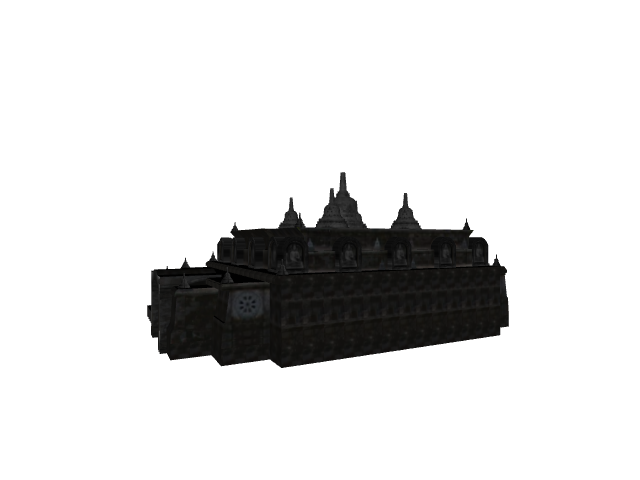

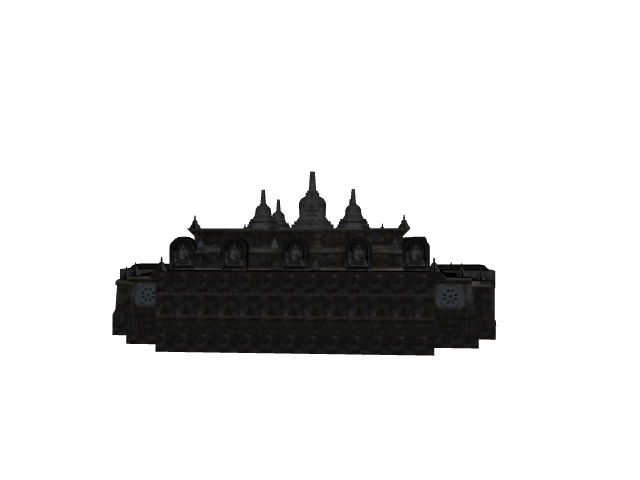

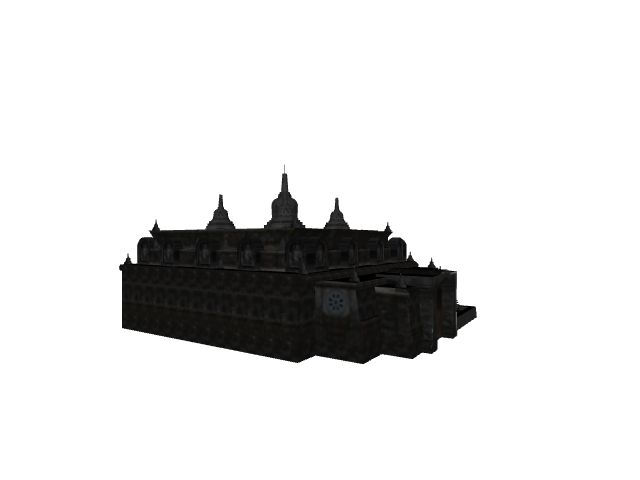

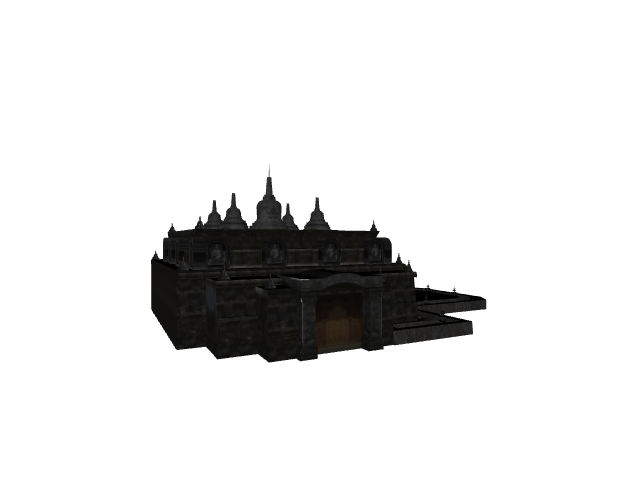

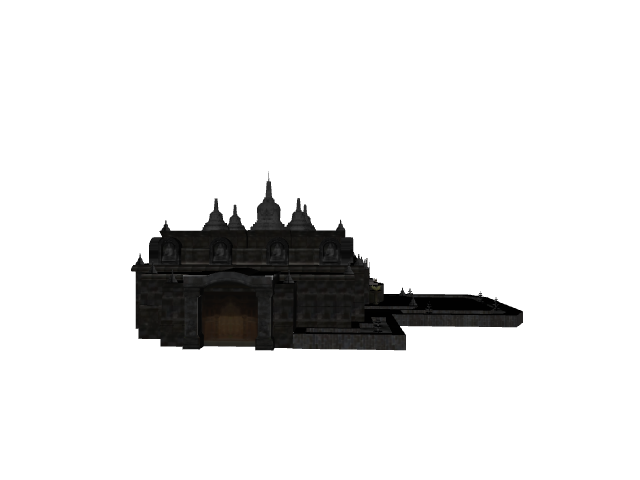

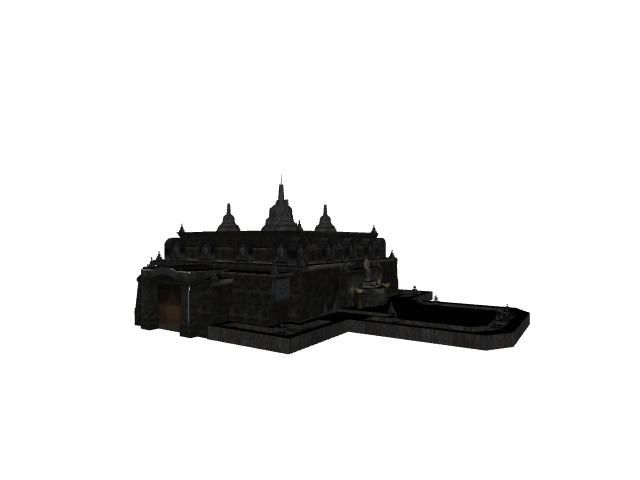

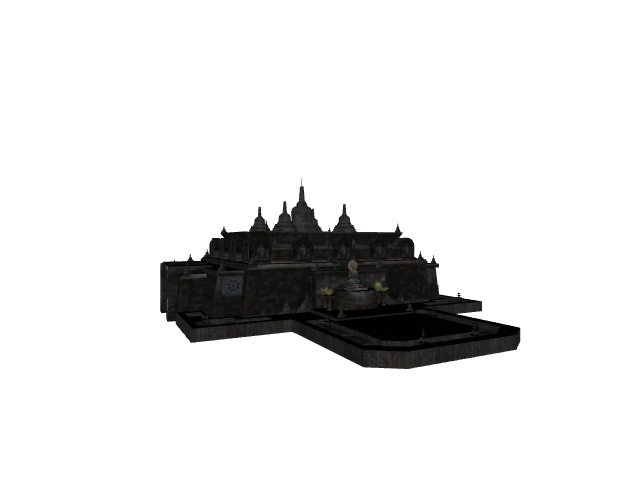

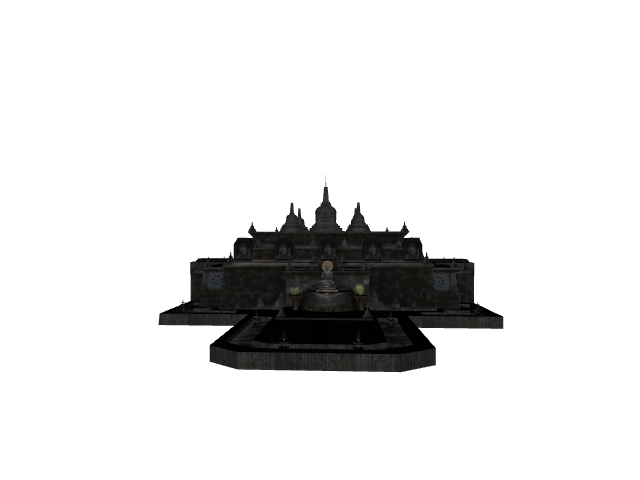

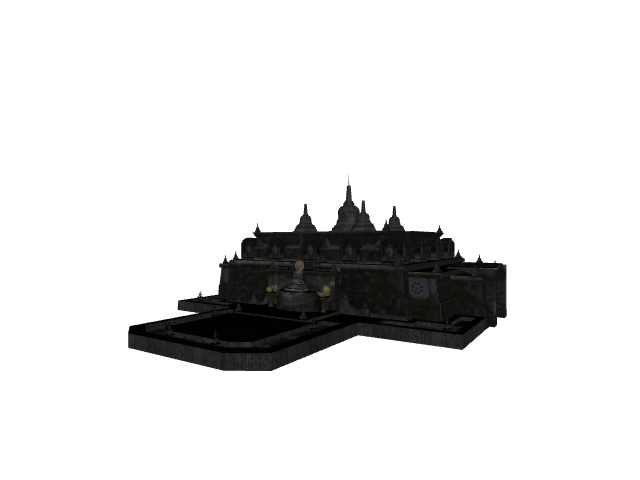

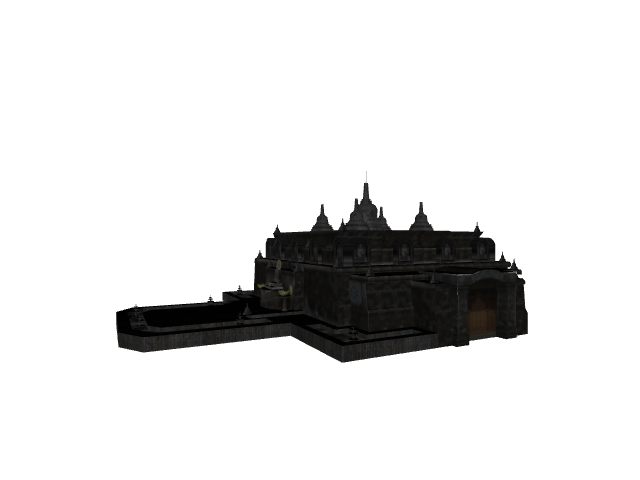

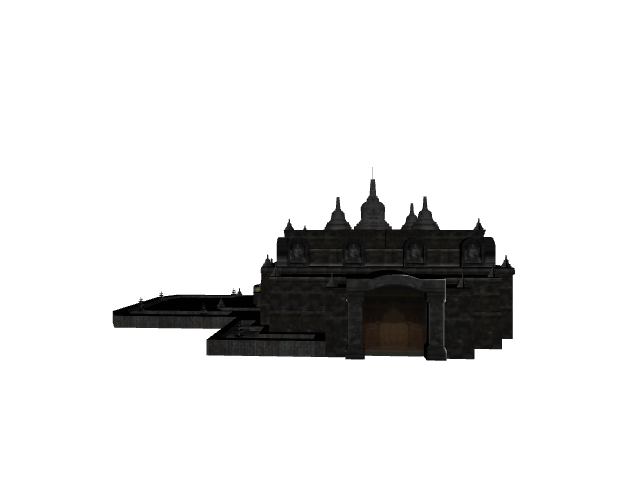

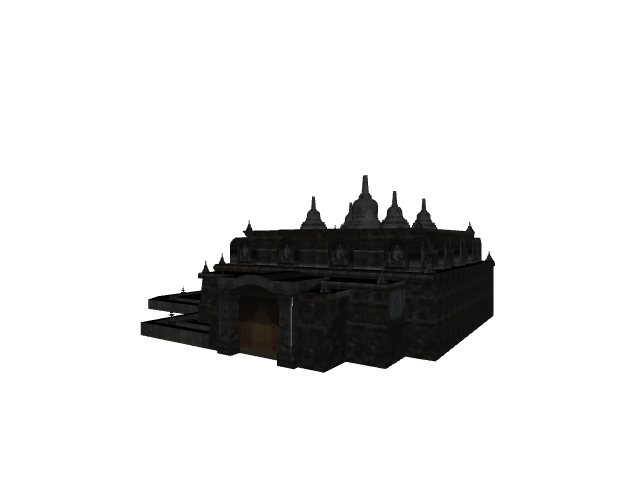

In [327]:
r = pyrender.OffscreenRenderer(viewport_width=640, viewport_height=480, point_size=1.0)

def rotate_y(angle):
    c = np.cos(angle)
    s = np.sin(angle)
    rotation_matrix = np.array(
        [[c, 0, s], [0, 1, 0], [-s, 0, c]]
    )
    return rotation_matrix

def pull_to_fit(xfov, scene: trimesh.Scene):
    # TODO: Could also compute this more concretely on specific viewing angle
    # by projecting a unified mesh of the scene onto a plane whose normal is
    # defined by the current camera angle, and using the bounding box of that to
    # compute this.
    obj_bbox = scene.dump(True).projected(np.array([0, 0, 1])).polygons_closed[0].bounds

    max_dim = np.max(obj_bbox[1] - obj_bbox[0])
    dist = max_dim / np.tan(xfov)
    center = (obj_bbox[0] + obj_bbox[1]) / 2
    camera_pos = center + [0, 0, 1.2 * dist]
    return camera_pos

def pull_to_fit_2(xfov, obj_bbox):
    padding = 0.1
    max_dim = np.max(obj_bbox[1] - obj_bbox[0]) + padding
    dist = max_dim / (2 * np.tan(xfov)) + max_dim / 2
    return np.array([0, 0, dist])

    

def look_at(camera_pos, target_pos):
    camera_z = (camera_pos - target_pos) / np.linalg.norm(camera_pos - target_pos)
    camera_x = np.cross(np.array([0, 1, 0]), camera_z)
    camera_x = camera_x / np.linalg.norm(camera_x)
    camera_y = np.cross(camera_z, camera_x)
    camera_pose = np.eye(4)
    camera_pose[:3, 0] = camera_x
    camera_pose[:3, 1] = camera_y
    camera_pose[:3, 2] = camera_z
    camera_pose[:3, 3] = camera_pos
    return camera_pose

for angle in np.linspace(0, 2 * np.pi, 12, endpoint=False):
    pyr_scene = pyrender.Scene.from_trimesh_scene(scene)

    camera_pos = (pull_to_fit_2(camera_xfov, scene.bounds) * rotate_y(angle))[:, 2]
    camera_yfov = np.pi / 3
    camera_aspect_ratio = 4.0 / 3.0
    camera_xfov = camera_yfov / camera_aspect_ratio
    camera_pose = look_at(camera_pos, np.array([0, 0, 0]))
    pyr_scene.main_camera_node = pyr_scene.add(
        pyrender.PerspectiveCamera(yfov=camera_yfov, aspectRatio=camera_aspect_ratio),
        pose=camera_pose,
    )
    pyr_scene.add(pyrender.DirectionalLight(color=[1.0, 1.0, 1.0], intensity=2.0), pose=camera_pose)

    color, depth = r.render(pyr_scene)
    im = Image.fromarray(color)
    im.show()

r.delete()
